# Simulate gamma ray sources in galaxy

In [7]:
#Imports
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import poisson, laplace, lognorm
from astropy.io import fits
from astropy.table import Table,join
%matplotlib inline
#constants 
kpc = 3.08567758e21 #cm
n = 1000 #Number of spaces in grid (r,z,flux)
model = 'C' #Set model to S or C
if model=='C':
    H=0.18
    alp=1.9
    bet = 5.0
if model=='S':
    H=0.33
    alp=0.2
    bet = 1.4
Rsun = 8.3

In [8]:
#Function definitions

def R_dep(R,alpha=alp, beta=bet):
    "R distribution of sources from lorimer"
    return ((R/Rsun)**alpha)*np.exp(-beta*(R-Rsun)/Rsun)

def rand_z(n,H=H):
    """Return random z from laplace distribution=exp(-abs(z))
    n = number of randoms"""
    return laplace.rvs(0,H,size=n)

def rand_L(u,a,Lmin,Lmax):
    if a==1:
        print "a==1, error"
        return 0
    return (u*(Lmax**(1-a)-Lmin**(1-a))+Lmin**(1-a))**(1/(1-a))

In [15]:
#Load 3fgl
file_3fgl = 'gll_psc_v16.fit'
data = fits.getdata(file_3fgl)
tb = Table(data)
cls = np.asarray(tb['CLASS1'].tolist())
cls = np.char.lower(np.char.rstrip(cls, ' '))
lat = tb['GLAT']
lon = tb['GLON']
#Sources to use, use unassosciated sources at low b?
gal = tb[(cls=='psr') | (cls =='pwn') | (cls=='snr') | (cls=='spp') | ((cls=='') & (np.abs(lat)<10) )]
lat_gal = gal['GLAT'] #l,b of gal sources
lon_gal = gal['GLON']
lon_gal[lon_gal>180]-=360
hb = 10 #This is considered as high latitude
high_lat_mask_3fgl = np.abs(lat_gal)>=hb
high_lat = gal[np.abs(lat_gal)>=hb]
flux_3fgl = np.array(gal['Flux1000'])
flux_3fgl_high_lat = high_lat['Flux1000']

#Trheshold of fermi, from 3fgl/3fhl? paper
fermi_thres = 5e-10#min_3fgl_high_lat 

#log n log s

N_3fgl = np.zeros(n)
flux_logspace = np.logspace(-12,-6,n)
#Create log n log s plot, deprecated??
for i,f in enumerate(flux_logspace):
    N_3fgl[i] = len(flux_3fgl[flux_3fgl > f])


-3.1405548874 3.12788719112
-1.3052522427 1.29674002057
flux in undetected: 1.11653296595e-06
total flux simulation  1.18487139219e-05
total flux 3fgl: 5.48606e-06
sources simulation high lat 95
sources 3fgl high lat 73


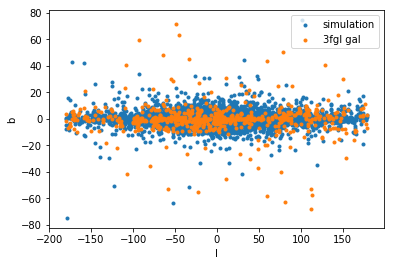

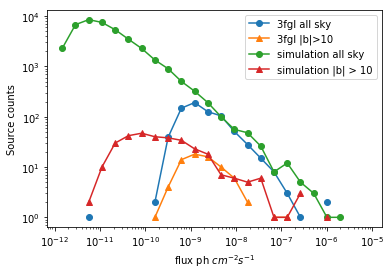

In [28]:
#Do the simulation monte carlo
def mc_smpl(a=2,N=1000,Lmin=3e34,Lmax=1e40):
    """Sample from above distribution N times: r,z,L and calculate flux as measured at earth"""
    N = int(N) #no samples just to be sure
    #set up R, has to be looped over, no analytical inverse 
    r = np.linspace(0.,50,n) 

    x0,y0,z0 = Rsun,0,0 #Location of us
    
    #set up pdf/cdf of desired distributions
    data_R = R_dep(r)
    data_R = data_R/np.sum(data_R)#normalize
    data_R_cdf = np.cumsum(data_R)#cdf
    #setup arrays for samples
    R_smpl = np.zeros(N)
    u = np.random.rand(N) #For R
    u2 = np.random.rand(N)# For L
    phi_smpl = np.random.rand(N)*2*np.pi #uniform distribution for phi
    L_smpl = rand_L(u2,a,Lmin,Lmax)#random L
    z_smpl = rand_z(N)
    for i in range(N):
        #Inverse transform sampling, numerical
        xx= np.argmax(u[i]<=data_R_cdf)
        R_smpl[i]=r[xx]
        
    #plot test
#    hist,bins = np.histogram(L_smpl, bins=np.logspace(35,39,50),density=True)
#    bins = (bins[0:-1]+bins[1:])/2.
#    plt.loglog(bins,hist,'bo')
#    plt.loglog(L,LF(L,Lmin))
#    plt.show()

    #distances from source to earth, calc flux
    x,y,z = R_smpl*np.cos(phi_smpl),R_smpl*np.sin(phi_smpl),z_smpl
    dist = ((x-x0))**2+((y-y0))**2+(z-z0)**2
    dist = dist*kpc**2
    flux_data = L_smpl/(4*np.pi*dist)
    
    #Make skymap, l,b. This seems overkill, is there a simpler way?

    #mask1 = (x<0)&(y>=0)
    #mask2 = (x<0)&(y<0)
    #mask3 = (x>=0)&(y<0)
    #mask4 = (x>=0)&(y>=0)
    #l = np.zeros_like(theta)
    #l[mask1]=np.arctan(np.abs(y[mask1])/np.abs(x[mask1]))
    #l[mask2]= -np.arctan(np.abs(y[mask2])/np.abs(x[mask2]))
    #l[mask3] = np.pi/2+np.arctan(np.abs(x[mask3])/np.abs(y[mask3]))
    #l[mask4] = -np.pi/2-np.arctan(np.abs(x[mask4])/np.abs(y[mask4]))
    #l = l*180/np.pi 
    b = np.arctan((z-z0)/np.sqrt((x-x0)**2+(y-y0)**2))
    l = np.arctan2((y0-y),(x0-x))
    #b = np.arctan(z/(x0-x))
    print min(l), max(l)
    print min(b), max(b)
    l = l*180/np.pi
    b = b*180/np.pi
    #High lat mask
    high_lat_mask = np.abs(b)>hb
    flux_high_lat = flux_data[high_lat_mask]
    flux_thres_high_lat = flux_high_lat[flux_high_lat>=fermi_thres]
    N_high_lat = len(flux_thres_high_lat)

    #Test plot l,b
    f = plt.figure()
    ax = f.add_subplot(111)
    ax.scatter(l,b,marker='.', label='simulation')
    ax.scatter(lon_gal,lat_gal, marker='.',label='3fgl gal')
    ax.set_xlabel('l')
    ax.set_ylabel('b')
    ax.legend()
    #setup logn-logs for simulated sources
    Ns = np.zeros(n)
    for i,f in enumerate(flux_logspace):
        Ns[i]= len(flux_data[flux_data > f])
        
    #Print some info
    detected = flux_data[flux_data >= fermi_thres]
    undetected = flux_data[flux_data < fermi_thres]
    flux_undet = np.sum(undetected)
    flux_det = np.sum(detected)
    print "flux in undetected:", flux_undet
    print "total flux simulation ", np.sum(flux_data)
    print "total flux 3fgl:", np.sum(flux_3fgl)
    print "sources simulation high lat", N_high_lat
    print "sources 3fgl high lat", len(flux_3fgl_high_lat)
    
    #Set up histogram of flux
    mc_hist,mc_bins = np.histogram(flux_data,bins=np.logspace(-12,-5,25))
    mc_hist_hb,mc_bins_hb = np.histogram(flux_data[high_lat_mask],bins=np.logspace(-12,-5,25))
    mc_bins= (mc_bins[1:]+mc_bins[0:-1])/2.
    return Ns,mc_hist,mc_bins,mc_hist_hb

#Lmin 3*10**34 according to abdo 2013
Ns,hist,bins,hist_hb = mc_smpl(1.8,40000,3e34,1e40)

#setup histograms
hist_3fgl, bins_3fgl = np.histogram(flux_3fgl, bins=np.logspace(-12,-5,25))
hist_3fgl_hb,bins_3fgl_hb = np.histogram(flux_3fgl[high_lat_mask_3fgl],bins=np.logspace(-12,-5,25))

#f1,ax1 = plt.subplots(1)
f2,ax2 = plt.subplots(1)
#ax1.set_title('log n-log s')
#ax1.set_xlabel(r'flux ph $cm^{-2} s^{-1}$')
#ax1.set_ylabel('Source counts flux>flux')
ax2.set_xlabel(r'flux ph $cm^{-2} s^{-1}$')
ax2.set_ylabel('Source counts')
#ax1.loglog(flux_logspace,N_3fgl,label='3FGL')
#ax1.axvline(fermi_thres, linewidth=2, color='b',label='thres')

bins_3fgl = (bins_3fgl[1:]+bins_3fgl[0:-1])/2.
ax2.loglog(bins_3fgl,hist_3fgl, marker='o',label='3fgl all sky')
ax2.loglog(bins_3fgl, hist_3fgl_hb, marker='^', label='3fgl |b|>10')

ax2.loglog(bins,hist,marker='o',label='simulation all sky')
ax2.loglog(bins,hist_hb,marker='^',label='simulation |b| > 10')
ax2.legend()

#f1.savefig('lognlogs.pdf')
f2.savefig('n_flux_allsky.pdf')
